# Group-9 || Natural Language Processing

# Importing Libraries:

In [11]:
import pandas as pd
import os
import re
import nltk
import string
from better_profanity import profanity
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from tqdm import tqdm 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# downloading stopwords
#ltk.download('stopwords')
#Loading dataset
data = pd.read_csv("tweets.csv")
data.shape
data.head(15)

,Unnamed: 0,Date,User,Tweet,Likes,Retweets
0,0,2023-03-29 15:42:36+00:00,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,0.0,0.0
1,1,2023-03-29 15:42:05+00:00,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",0.0,0.0
2,2,2023-03-29 15:34:29+00:00,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,0.0,0.0
3,3,2023-03-29 15:31:43+00:00,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...,0.0,0.0
4,4,2023-03-29 15:26:48+00:00,itweetsensee,@annamalai_k @narendramodi A state level presi...,0.0,0.0
5,5,2023-03-29 15:21:29+00:00,FreeMindKeenEye,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,0.0,0.0
6,6,2023-03-29 15:20:41+00:00,SamsSamsson6,@darrengrimes_ Why are pakistani /indian dual ...,0.0,0.0
7,7,2023-03-29 15:20:16+00:00,SamsSamsson6,@PeterStefanovi2 Why are pakistani /indian dua...,0.0,0.0
8,8,2023-03-29 15:19:44+00:00,SamsSamsson6,Why are pakistani /indian dual nationals allow...,0.0,0.0
9,9,2023-03-29 15:19:32+00:00,ncsukumar1,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,0.0,0.0


# Description of data:

In [12]:
data.isna().sum()

Unnamed: 0    0
Date          0
User          0
Tweet         1
Likes         2
Retweets      2
dtype: int64

In [13]:
#Removing duplicates
data.dropna(inplace=True)

In [14]:
data.duplicated().sum()

0

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49999 entries, 0 to 50000
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  49999 non-null  object 
 1   Date        49999 non-null  object 
 2   User        49999 non-null  object 
 3   Tweet       49999 non-null  object 
 4   Likes       49999 non-null  float64
 5   Retweets    49999 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.7+ MB


In [16]:
data.nunique()

Unnamed: 0    49999
Date          49820
User          35108
Tweet         49568
Likes           598
Retweets        312
dtype: int64

# Preprocessing:

In [17]:
#Identifying numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
#Identifying categorical columns
categorical_cols = data.select_dtypes(exclude=['number']).columns.tolist()

#Printing the lists of numerical and categorical columns
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['Likes', 'Retweets']
Categorical columns: ['Unnamed: 0', 'Date', 'User', 'Tweet']


In [18]:
#Copying the 'Tweet' column to a new 'Original_Tweet' column
data['Unprocessed_Tweets'] = data['Tweet']

#Creating a new 'Date&Time' column and drop the 'Date' column
data['Date&Time'] = data['Date']
data = data.drop('Date', axis=1)

#Splitting the 'Date&Time' column to remove the time zone information
data['Date&Time'] = data['Date&Time'].str.split('+').str[0]

#Converting the 'Processed_DateTime' column to datetime format and replace invalid values with a default datetime
data['Date&Time'] = pd.to_datetime(data['Date&Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S').fillna(pd.Timestamp('1900-01-01'))

#Extracting 'Processed_Date', 'Processed_Month', 'Processed_Year', and 'Processed_Hour' from the 'Processed_DateTime' column
data['Prcsd_Date'] = data['Date&Time'].dt.date
data['Prcsd_Month'] = data['Date&Time'].dt.month
data['Prcsd_Year'] = data['Date&Time'].dt.year
data['Prcsd_Hour'] = data['Date&Time'].dt.hour

# Display the updated DataFrame
data.head(15)

,Unnamed: 0,User,Tweet,Likes,Retweets,Unprocessed_Tweets,Date&Time,Prcsd_Date,Prcsd_Month,Prcsd_Year,Prcsd_Hour
0,0,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,0.0,0.0,@vinodkapri @RahulGandhi Respected Indian Citi...,2023-03-29 15:42:36,2023-03-29,3,2023,15
1,1,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",0.0,0.0,"*Respected Indian Citizens,* Namaskaar I Am Th...",2023-03-29 15:42:05,2023-03-29,3,2023,15
2,2,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,0.0,0.0,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,2023-03-29 15:34:29,2023-03-29,3,2023,15
3,3,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...,0.0,0.0,@MrinalWahal Why would politicians stop using ...,2023-03-29 15:31:43,2023-03-29,3,2023,15
4,4,itweetsensee,@annamalai_k @narendramodi A state level presi...,0.0,0.0,@annamalai_k @narendramodi A state level presi...,2023-03-29 15:26:48,2023-03-29,3,2023,15
5,5,FreeMindKeenEye,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,0.0,0.0,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,2023-03-29 15:21:29,2023-03-29,3,2023,15
6,6,SamsSamsson6,@darrengrimes_ Why are pakistani /indian dual ...,0.0,0.0,@darrengrimes_ Why are pakistani /indian dual ...,2023-03-29 15:20:41,2023-03-29,3,2023,15
7,7,SamsSamsson6,@PeterStefanovi2 Why are pakistani /indian dua...,0.0,0.0,@PeterStefanovi2 Why are pakistani /indian dua...,2023-03-29 15:20:16,2023-03-29,3,2023,15
8,8,SamsSamsson6,Why are pakistani /indian dual nationals allow...,0.0,0.0,Why are pakistani /indian dual nationals allow...,2023-03-29 15:19:44,2023-03-29,3,2023,15
9,9,ncsukumar1,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,0.0,0.0,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,2023-03-29 15:19:32,2023-03-29,3,2023,15


In [21]:
#Defining the stopwords list
stop_words = stopwords.words('english')

#Creating a function to preprocess and clean the tweets
def preprocess_and_clean_text(text):
    # Remove non-ASCII characters and URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    #Convert text to lowercase
    text = text.lower()
    #Censoring profanity
    profanity.load_censor_words()
    text = profanity.censor(text)
    #Removing Twitter handles
    text = re.sub('@[^\s]+', '', text)
    #Removing hashtags
    text = re.sub(r'\B#\S+', '', text)
    #Removing special characters and punctuations (except single quotes)
    text = re.sub(r'[^\w\s\']', ' ', text) 
    #Removing single characters (except for 'a' and 'i')
    text = re.sub(r'\s+[a-hj-z]\s+', ' ', text)
    text = re.sub(r'\s+i\s+', ' I ', text)
    text = re.sub(r'\s+a\s+', ' a ', text)
    #Replacing multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    #Tokenization
    tokens = word_tokenize(text)
    #Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [22]:
# Apply the preprocessing function to the 'Tweet' column with tqdm progress bar
tqdm.pandas()
data['Cleaned_Tweet'] = data['Tweet'].progress_apply(preprocess_and_clean_text)

# Check the cleaned dataset
data.head(15)

100%|██████████████████████████████████████████████████████████████████████████| 49999/49999 [1:08:04<00:00, 12.24it/s]


,Unnamed: 0,User,Tweet,Likes,Retweets,Unprocessed_Tweets,Date&Time,Prcsd_Date,Prcsd_Month,Prcsd_Year,Prcsd_Hour,Cleaned_Tweet
0,0,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,0.0,0.0,@vinodkapri @RahulGandhi Respected Indian Citi...,2023-03-29 15:42:36,2023-03-29,3,2023,15,respected indian citizens namaskaari original ...
1,1,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",0.0,0.0,"*Respected Indian Citizens,* Namaskaar I Am Th...",2023-03-29 15:42:05,2023-03-29,3,2023,15,respected indian citizens namaskaar I original...
2,2,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,0.0,0.0,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,2023-03-29 15:34:29,2023-03-29,3,2023,15,1 meet filmmaker prakash jha new jersey talkin...
3,3,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...,0.0,0.0,@MrinalWahal Why would politicians stop using ...,2023-03-29 15:31:43,2023-03-29,3,2023,15,would politicians stop using religion politics...
4,4,itweetsensee,@annamalai_k @narendramodi A state level presi...,0.0,0.0,@annamalai_k @narendramodi A state level presi...,2023-03-29 15:26:48,2023-03-29,3,2023,15,state level president knows policy pm union mi...
5,5,FreeMindKeenEye,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,0.0,0.0,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,2023-03-29 15:21:29,2023-03-29,3,2023,15,ok lady issues us poke dirty nose indian polit...
6,6,SamsSamsson6,@darrengrimes_ Why are pakistani /indian dual ...,0.0,0.0,@darrengrimes_ Why are pakistani /indian dual ...,2023-03-29 15:20:41,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...
7,7,SamsSamsson6,@PeterStefanovi2 Why are pakistani /indian dua...,0.0,0.0,@PeterStefanovi2 Why are pakistani /indian dua...,2023-03-29 15:20:16,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...
8,8,SamsSamsson6,Why are pakistani /indian dual nationals allow...,0.0,0.0,Why are pakistani /indian dual nationals allow...,2023-03-29 15:19:44,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...
9,9,ncsukumar1,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,0.0,0.0,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,2023-03-29 15:19:32,2023-03-29,3,2023,15,problem indian politics politicians n't rememb...


In [23]:
# Export the DataFrame to a CSV file
data.to_csv("cleaned_tweets.csv", index=False)

# Classifying Sentiments

In [25]:
# Creating a function to get sentiment polarity
def get_polarity(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

# Creating a function to get sentiment
def get_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

tqdm.pandas()
# Applying the functions to the 'Cleaned_Tweet' column to create 'Polarity' and 'Sentiment' columns
data['Polarity'] = data['Cleaned_Tweet'].apply(get_polarity)
data['Sentiment'] = data['Polarity'].apply(get_sentiment)

# Checking the DataFrame with the new columns
data.head(15)

,Unnamed: 0,User,Tweet,Likes,Retweets,Unprocessed_Tweets,Date&Time,Prcsd_Date,Prcsd_Month,Prcsd_Year,Prcsd_Hour,Cleaned_Tweet,Polarity,Sentiment
0,0,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,0.0,0.0,@vinodkapri @RahulGandhi Respected Indian Citi...,2023-03-29 15:42:36,2023-03-29,3,2023,15,respected indian citizens namaskaari original ...,-0.062500,Negative
1,1,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",0.0,0.0,"*Respected Indian Citizens,* Namaskaar I Am Th...",2023-03-29 15:42:05,2023-03-29,3,2023,15,respected indian citizens namaskaar I original...,-0.062500,Negative
2,2,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,0.0,0.0,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,2023-03-29 15:34:29,2023-03-29,3,2023,15,1 meet filmmaker prakash jha new jersey talkin...,0.173232,Positive
3,3,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...,0.0,0.0,@MrinalWahal Why would politicians stop using ...,2023-03-29 15:31:43,2023-03-29,3,2023,15,would politicians stop using religion politics...,0.000000,Neutral
4,4,itweetsensee,@annamalai_k @narendramodi A state level presi...,0.0,0.0,@annamalai_k @narendramodi A state level presi...,2023-03-29 15:26:48,2023-03-29,3,2023,15,state level president knows policy pm union mi...,0.214286,Positive
5,5,FreeMindKeenEye,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,0.0,0.0,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,2023-03-29 15:21:29,2023-03-29,3,2023,15,ok lady issues us poke dirty nose indian polit...,-0.033333,Negative
6,6,SamsSamsson6,@darrengrimes_ Why are pakistani /indian dual ...,0.0,0.0,@darrengrimes_ Why are pakistani /indian dual ...,2023-03-29 15:20:41,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...,0.000000,Neutral
7,7,SamsSamsson6,@PeterStefanovi2 Why are pakistani /indian dua...,0.0,0.0,@PeterStefanovi2 Why are pakistani /indian dua...,2023-03-29 15:20:16,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...,0.000000,Neutral
8,8,SamsSamsson6,Why are pakistani /indian dual nationals allow...,0.0,0.0,Why are pakistani /indian dual nationals allow...,2023-03-29 15:19:44,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...,0.000000,Neutral
9,9,ncsukumar1,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,0.0,0.0,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,2023-03-29 15:19:32,2023-03-29,3,2023,15,problem indian politics politicians n't rememb...,-0.111111,Negative


In [26]:
# Exporting the DataFrame to a CSV file
data.to_csv("Classified_tweets.csv", index=False)

# Exploratory Data Analysis:

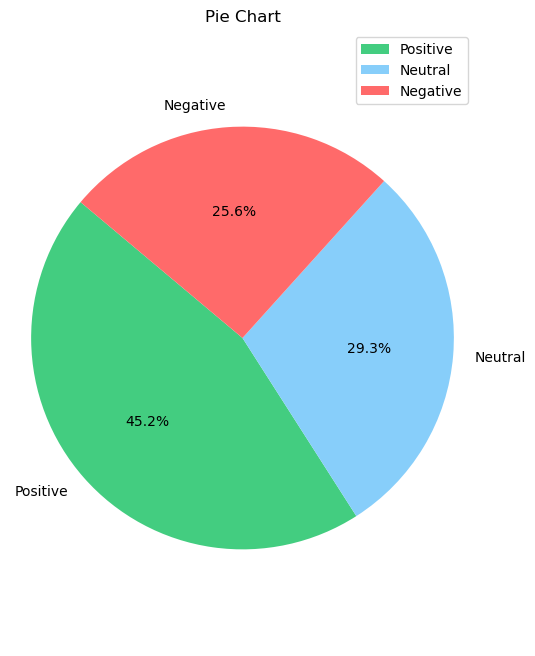

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Counting the occurrences of each sentiment category
sentiment_counts = data['Sentiment'].value_counts()

# Setting color hex codes for each sentiment category
colors = ['#43CD80', '#87CEFA', '#FF6A6A']  # You can customize the colors

# Creating a pie chart
plt.figure(figsize=(6, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart')
plt.legend(sentiment_counts.index, loc='upper right')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

#displaying the pie chart
plt.show()

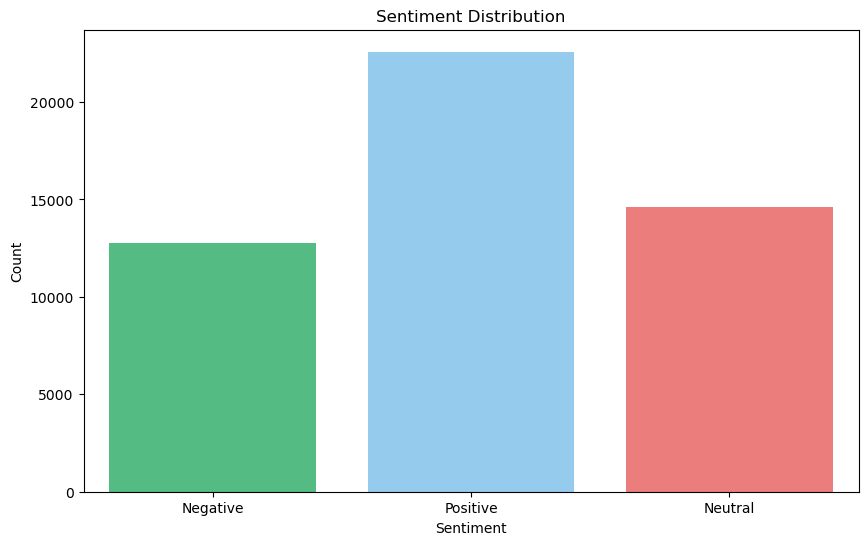

In [84]:
# Creating a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Sentiment', palette=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
# Show the bar chart
plt.show()

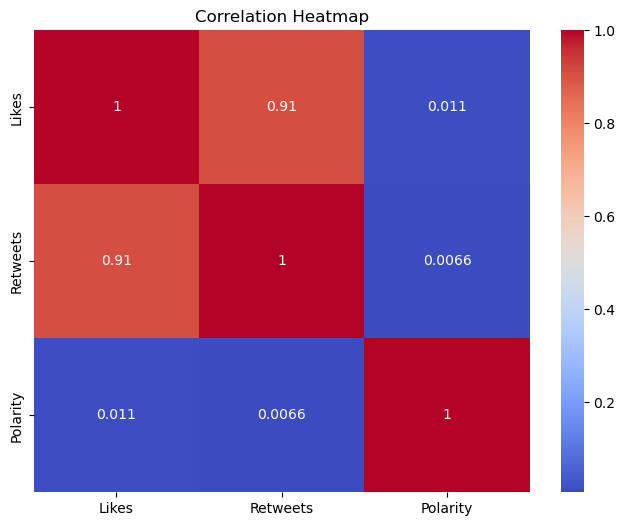

In [70]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data[['Likes', 'Retweets', 'Polarity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

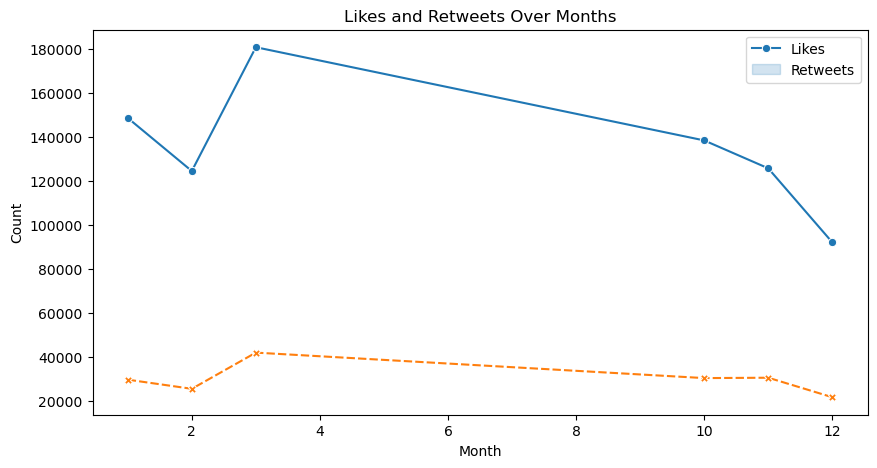

In [71]:
# Time Series Analysis - Likes and Retweets over Months
monthly_likes_retweets = data.groupby('Prcsd_Month')[['Likes', 'Retweets']].sum()
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_likes_retweets, markers=True,)
plt.title('Likes and Retweets Over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(['Likes', 'Retweets'])
plt.show()

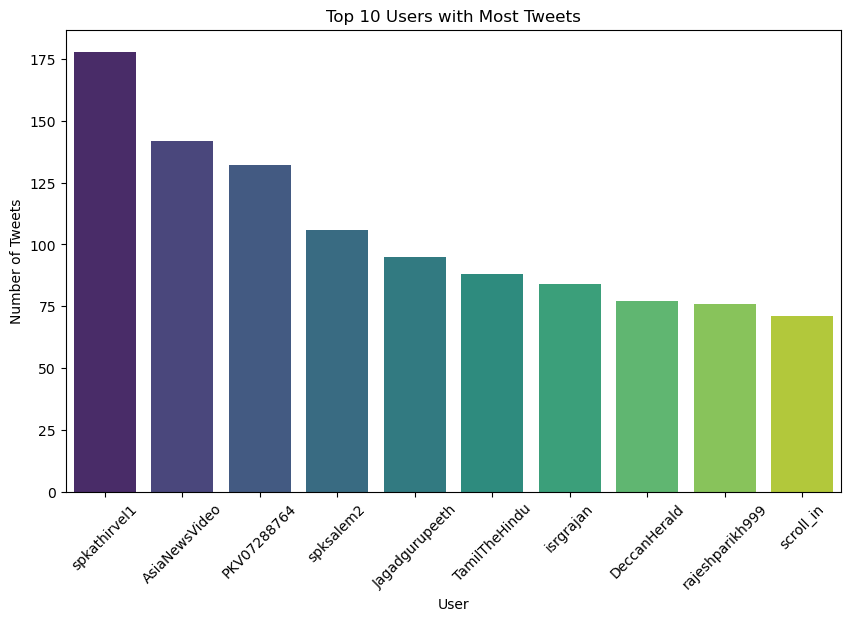

In [44]:
# User Analysis - Number of Tweets by Each User
user_tweet_counts = data['User'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=user_tweet_counts.index[:10], y=user_tweet_counts.values[:10], palette='viridis')
plt.title('Top 10 Users with Most Tweets')
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

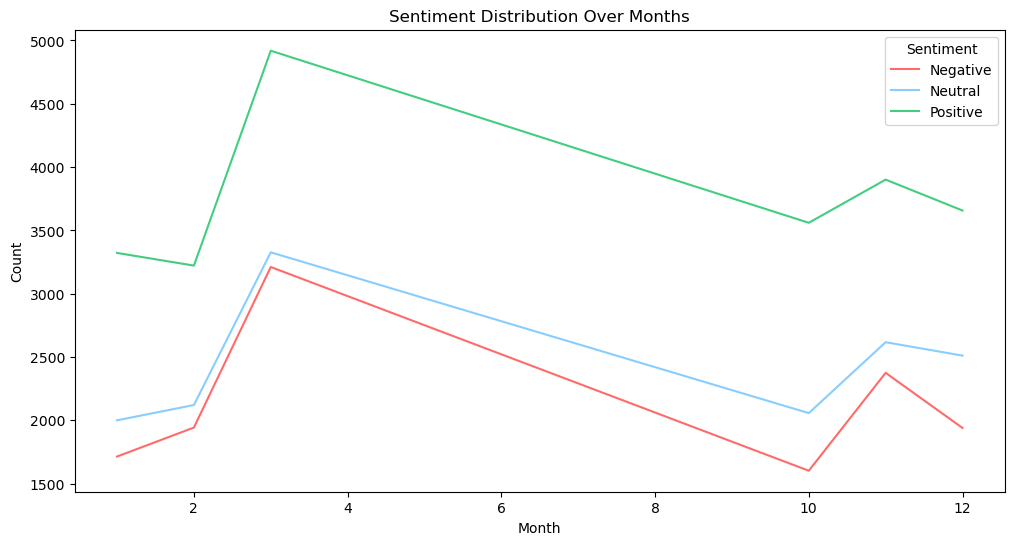

In [85]:
# Define color codes for sentiments
sentiment_colors = {
    'Positive': '#43CD80',
    'Negative': '#FF6A6A',
    'Neutral': '#87CEFF'
}
# Sentiment Distribution Over Time - Line Plot
sentiment_over_time = data.groupby(['Prcsd_Year', 'Prcsd_Month', 'Sentiment']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_over_time, x='Prcsd_Month', y='Count', hue='Sentiment', markers=True, palette=sentiment_colors)
plt.title('Sentiment Distribution Over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

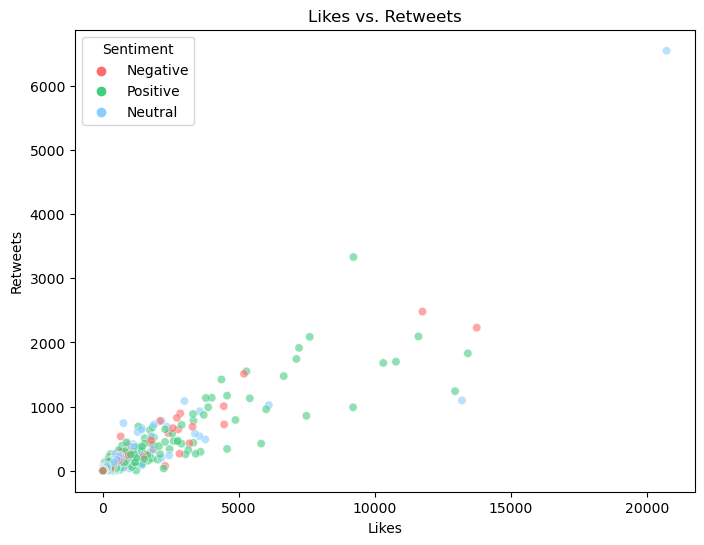

In [86]:
# Likes vs. Retweets Analysis - Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Likes', y='Retweets', hue='Sentiment', palette=sentiment_colors, alpha=0.6)
plt.title('Likes vs. Retweets')
plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.legend(title='Sentiment')
plt.show()

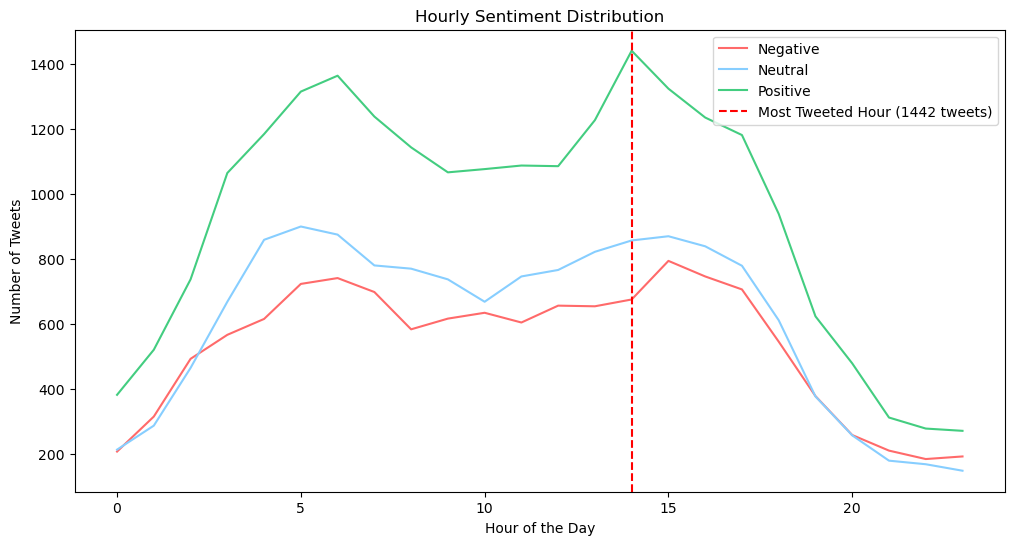

Total Positive Tweets: 1325
Total Negative Tweets: 794
Total Neutral Tweets: 870


In [87]:
# Hourly Sentiment Distribution - Line Plot
hourly_sentiments = data[['Prcsd_Hour', 'Sentiment']]
hourly_sentiment_counts = hourly_sentiments.groupby(['Prcsd_Hour', 'Sentiment']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_sentiment_counts, x='Prcsd_Hour', y='Count', hue='Sentiment', markers=True, palette=sentiment_colors)
plt.title('Hourly Sentiment Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')

# Highlight the hour with the most tweets
most_tweeted_hour = hourly_sentiment_counts.loc[hourly_sentiment_counts['Count'].idxmax()]['Prcsd_Hour']
most_tweets_count = hourly_sentiment_counts['Count'].max()
plt.axvline(x=most_tweeted_hour, color='red', linestyle='--', label=f'Most Tweeted Hour ({most_tweets_count} tweets)')
plt.legend()
plt.show()

print(f"Total Positive Tweets: {positive_tweets}")
print(f"Total Negative Tweets: {negative_tweets}")
print(f"Total Neutral Tweets: {neutral_tweets}")

In [88]:
# Hourly Sentiment Distribution - Polar Line Plot
def format_hour(h: int):
    return f"{h:02d}:00"
sentiment_hourly = data.groupby(['Sentiment', 'Prcsd_Hour'])['Tweet'].count().reset_index()
sentiment_hourly.columns = ['Sentiment', 'Hour of Day', 'Number of Tweets']
sentiment_hourly['Hour of Day'] = sentiment_hourly['Hour of Day'].apply(format_hour)
most_tweeted_hour = sentiment_hourly[sentiment_hourly['Number of Tweets'] == sentiment_hourly['Number of Tweets'].max()]['Hour of Day'].values[0]
most_tweets_count = sentiment_hourly['Number of Tweets'].max()

fig = go.Figure()
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_data = sentiment_hourly[sentiment_hourly['Sentiment'] == sentiment]
    fig.add_trace(go.Scatterpolar(
        r=sentiment_data['Number of Tweets'],
        theta=sentiment_data['Hour of Day'],
        name=sentiment,
        line=dict(dash='solid' if sentiment == 'Positive' else 'dash' if sentiment == 'Negative' else 'dot'),
        legendgroup=sentiment,
        marker_color=sentiment_colors[sentiment],
    ))

fig.add_trace(go.Scatterpolar(
    r=[most_tweets_count] * 3,
    theta=[most_tweeted_hour] * 3,
    mode='lines+text',
    text=[f'Most Tweeted Hour ({most_tweets_count} tweets)'] * 3,
    textposition='bottom center',
    line=dict(color='red', width=2),
    legendgroup='Most Tweeted Hour',
))

fig.update_layout(
    title="Time of Day - Number of Positive, Negative, and Neutral Tweets",
    title_x=0.5,
    polar_angularaxis=dict(
        direction="clockwise",
        tickvals=list(range(24)),
        ticktext=[format_hour(h) for h in range(24)],
        showline=False,
    ),
    legend=dict(x=0.85, y=0.95),
)

fig.show()

# Print the hour with the most tweets
print(f"Hour with the most tweets: {most_tweeted_hour} (Total Tweets: {most_tweets_count})")

Hour with the most tweets: 14:00 (Total Tweets: 1442)


In [89]:
#  Function to format the hour
def format_hour(h: int):
    return f"{h:02d}:00"

# Group by Sentiment and hour, and count the number of tweets
sentiment_hourly = data.groupby(['Sentiment', 'Prcsd_Hour'])['Tweet'].count().reset_index()
sentiment_hourly.columns = ['Sentiment', 'Hour of Day', 'Number of Tweets']
sentiment_hourly['Hour of Day'] = sentiment_hourly['Hour of Day'].apply(format_hour)

# Create a bar plot
fig = px.bar(
    sentiment_hourly,
    x='Hour of Day',
    y='Number of Tweets',
    color='Sentiment',
    color_discrete_sequence=['#FF6A6A', '#87CEFF', '#43CD80'],
    title='Hourly Number of Tweets by Sentiment',
)

# Customize the x-axis tick positions and labels
custom_x_ticks = [format_hour(h) for h in range(0, 24, 4)]  # Every 4 hours
fig.update_xaxes(
    tickvals=[format_hour(h) for h in range(0, 24, 4)],
    ticktext=custom_x_ticks,
)

fig.update_layout(
    xaxis_title='Hour of Day',
    yaxis_title='Number of Tweets',
    legend_title='Sentiment',
)

fig.show()

In [90]:
# Function to format the month
def format_month(m: int):
    return f"{m:02d}"

# Define the desired order for months
month_order = [format_month(month) for month in range(1, 4)]  # January to December

# Group by Sentiment and month, and count the number of tweets
sentiment_monthly = data.groupby(['Sentiment', 'Prcsd_Month'])['Tweet'].count().reset_index()
sentiment_monthly.columns = ['Sentiment', 'Month', 'Number of Tweets']
sentiment_monthly['Month'] = sentiment_monthly['Month'].apply(format_month)

# Create a bar plot with custom month order
fig = px.bar(
    sentiment_monthly,
    x='Month',
    y='Number of Tweets',
    color='Sentiment',
    color_discrete_sequence=['#FF6A6A', '#87CEFF', '#43CD80'],
    title='Monthly Number of Tweets by Sentiment',
)

fig.update_xaxes(categoryorder='array', categoryarray=month_order)  # Specify the desired order

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Tweets',
    legend_title='Sentiment',
)

fig.show()

# Hypothesis testing:

In [122]:
import numpy as np
from scipy import stats

positive_likes = data[data['Sentiment'] == 'Positive']['Likes']
negative_likes = data[data['Sentiment'] == 'Negative']['Likes']

# Defining hypotheses
alpha = 0.05  # Significance level

# Performing an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(positive_likes, negative_likes, equal_var=False)

# Compare p-value to alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean likes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean likes.")

# Print the test statistic and p-value
print("t-statistic:", t_stat)
print("p-value:", p_value)

Reject the null hypothesis. There is a significant difference in mean likes.
t-statistic: 2.97172678116093
p-value: 0.002963426925918598


# Naive Bayes:

In [146]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Split the data into training and testing sets
X = data['Cleaned_Tweet']
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2600)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predict sentiments on the testing set
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7075
Classification Report:
               precision    recall  f1-score   support

    Negative       0.88      0.51      0.65      2656
     Neutral       0.85      0.49      0.62      2812
    Positive       0.64      0.96      0.76      4532

    accuracy                           0.71     10000
   macro avg       0.79      0.65      0.68     10000
weighted avg       0.76      0.71      0.69     10000



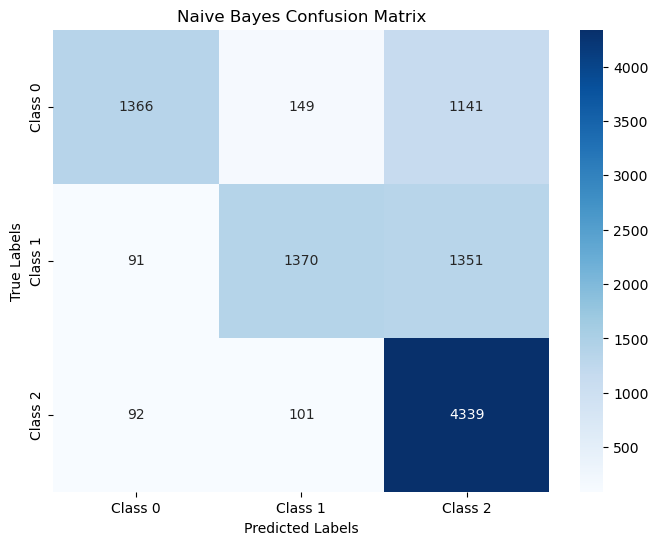

In [147]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ['Class 0', 'Class 1', 'Class 2']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Deep Neural network polynomial classifier:

In [154]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [155]:
# X should contain the preprocessed text data, and y should contain sentiment labels
X = data['Cleaned_Tweet'].values
y = data['Sentiment'].values

# Encode sentiment labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Set the maximum number of words to consider in your vocabulary
max_sequence_length = 100  # Set the maximum length of your sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust the output units based on the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [156]:
epochs = 10  # Adjust the number of training epochs as needed
model.fit(X_train_pad, y_train, epochs=epochs, validation_data=(X_test_pad, y_test))

Epoch 1/10
1250/1250 [==============================] - 37s 29ms/step - loss: 0.5006 - accuracy: 0.7959 - val_loss: 0.2446 - val_accuracy: 0.9192
Epoch 2/10
1250/1250 [==============================] - 37s 30ms/step - loss: 0.1087 - accuracy: 0.9676 - val_loss: 0.2750 - val_accuracy: 0.9166
Epoch 3/10
1250/1250 [==============================] - 40s 32ms/step - loss: 0.0336 - accuracy: 0.9904 - val_loss: 0.4012 - val_accuracy: 0.9105
Epoch 4/10
1250/1250 [==============================] - 38s 30ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.3970 - val_accuracy: 0.9106
Epoch 5/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.0166 - accuracy: 0.9947 - val_loss: 0.4200 - val_accuracy: 0.9093
Epoch 6/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.5063 - val_accuracy: 0.8992
Epoch 7/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.5418 -

313/313 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.83      0.87      2656
     Neutral       0.94      0.92      0.93      2812
    Positive       0.89      0.95      0.92      4532

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



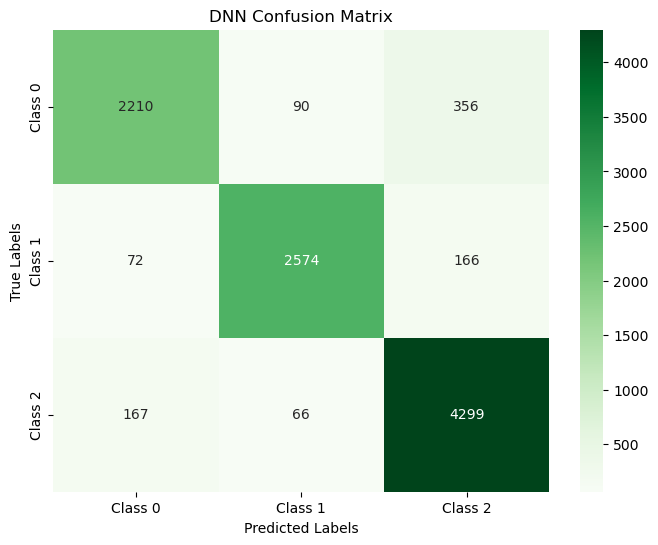

In [157]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
confusion_DNN=confusion_matrix(y_test, y_pred_classes)

# Define class labels
class_labels2 = ['Class 0', 'Class 1', 'Class 2']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_DNN, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels2, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DNN Confusion Matrix')
plt.show()

We can observe that Deep neural network model has higher accuracy than Naive Bayes.

# Topic Extraction:

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform your text data
tfidf_matrix = tfidf_vectorizer.fit_transform(X)

# Apply Latent Dirichlet Allocation (LDA)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=4, random_state=42)

In [163]:
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10  # We can Adjust the number of top words to display
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}:", top_words)

Topic 0: ['indian', 'politics', 'people', 'india', 'amp', 'leader', 'know', 'political', 'ultimate', 'modi']
Topic 1: ['politics', 'indian', 'india', 'bjp', 'people', 'amp', 'congress', 'like', 'party', 'gandhi']
Topic 2: ['indian', 'politics', 'india', 'amp', 'people', 'like', 'party', 'congress', 'country', 'news']
Topic 3: ['indian', 'politics', 'cricket', 'team', 'biggest', 'fraud', 'ji', 'bcci', 'hai', 'rahul']


In [164]:
doc_topic_matrix = lda.transform(tfidf_matrix)

In [174]:
# Assign topic labels based on the content
topic_labels = {
    0: 'Indian Politics and Leadership',
    1: 'Political Parties in India',
    2: 'Indian Political Issues and News',
    3: 'Indian Cricket and Sports'
}

#Explore Document Topics and assign the dominant topic label to each document
dominant_topic_labels = []
for doc_topic_distribution in doc_topic_matrix:
    dominant_topic = doc_topic_distribution.argmax()
    dominant_topic_labels.append(topic_labels[dominant_topic])

# Add the "Topic" column to your original DataFrame
data['Topic'] = dominant_topic_labels
data.head(15)

,Unnamed: 0,User,Tweet,Likes,Retweets,Unprocessed_Tweets,Date&Time,Prcsd_Date,Prcsd_Month,Prcsd_Year,Prcsd_Hour,Cleaned_Tweet,Polarity,Sentiment,Topic
0,0,AnandPatni8,@vinodkapri @RahulGandhi Respected Indian Citi...,0.0,0.0,@vinodkapri @RahulGandhi Respected Indian Citi...,2023-03-29 15:42:36,2023-03-29,3,2023,15,respected indian citizens namaskaari original ...,-0.062500,Negative,Indian Political Issues and News
1,1,dhinamum,"*Respected Indian Citizens,* Namaskaar I Am Th...",0.0,0.0,"*Respected Indian Citizens,* Namaskaar I Am Th...",2023-03-29 15:42:05,2023-03-29,3,2023,15,respected indian citizens namaskaar I original...,-0.062500,Negative,Indian Political Issues and News
2,2,PrincetonCGI,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,0.0,0.0,1/n-Meet Filmmaker Prakash Jha in New Jersey t...,2023-03-29 15:34:29,2023-03-29,3,2023,15,1 meet filmmaker prakash jha new jersey talkin...,0.173232,Positive,Indian Political Issues and News
3,3,RishiJoeSanu,@MrinalWahal Why would politicians stop using ...,0.0,0.0,@MrinalWahal Why would politicians stop using ...,2023-03-29 15:31:43,2023-03-29,3,2023,15,would politicians stop using religion politics...,0.000000,Neutral,Political Parties in India
4,4,itweetsensee,@annamalai_k @narendramodi A state level presi...,0.0,0.0,@annamalai_k @narendramodi A state level presi...,2023-03-29 15:26:48,2023-03-29,3,2023,15,state level president knows policy pm union mi...,0.214286,Positive,Political Parties in India
5,5,FreeMindKeenEye,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,0.0,0.0,@IAMCouncil @POTUS @Ilhan @bridgeinit OK this ...,2023-03-29 15:21:29,2023-03-29,3,2023,15,ok lady issues us poke dirty nose indian polit...,-0.033333,Negative,Indian Political Issues and News
6,6,SamsSamsson6,@darrengrimes_ Why are pakistani /indian dual ...,0.0,0.0,@darrengrimes_ Why are pakistani /indian dual ...,2023-03-29 15:20:41,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...,0.000000,Neutral,Political Parties in India
7,7,SamsSamsson6,@PeterStefanovi2 Why are pakistani /indian dua...,0.0,0.0,@PeterStefanovi2 Why are pakistani /indian dua...,2023-03-29 15:20:16,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...,0.000000,Neutral,Political Parties in India
8,8,SamsSamsson6,Why are pakistani /indian dual nationals allow...,0.0,0.0,Why are pakistani /indian dual nationals allow...,2023-03-29 15:19:44,2023-03-29,3,2023,15,pakistani indian dual nationals allowed uk pol...,0.000000,Neutral,Political Parties in India
9,9,ncsukumar1,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,0.0,0.0,@BesuraTaansane @KartiPC @PChidambaram_IN The ...,2023-03-29 15:19:32,2023-03-29,3,2023,15,problem indian politics politicians n't rememb...,-0.111111,Negative,Indian Politics and Leadership


In [182]:
# Export the DataFrame to a CSV file
data.to_csv("Final_data.csv", index=False)

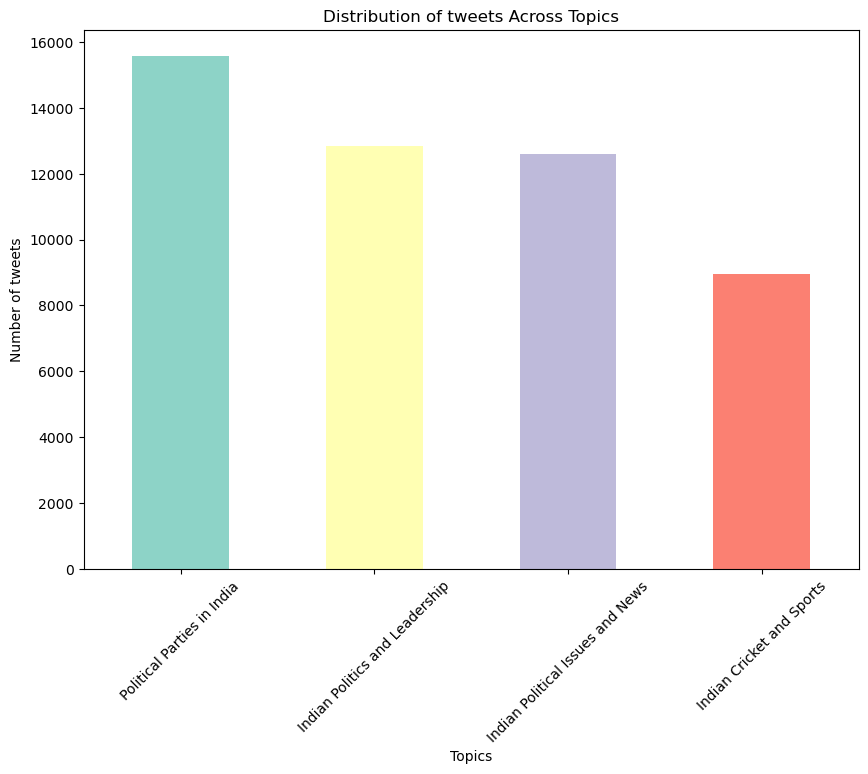

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Define a color palette for the topics
topic_colors = sns.color_palette("Set3", n_colors=len(topic_labels))

# Plot the topic distribution
topic_counts = data['Topic'].value_counts()
plt.figure(figsize=(10, 7))
topic_counts.plot(kind='bar', color=topic_colors)  # Use the color palette
plt.xlabel('Topics')
plt.ylabel('Number of tweets')
plt.title('Distribution of tweets Across Topics')
plt.xticks(rotation=45)
plt.show()

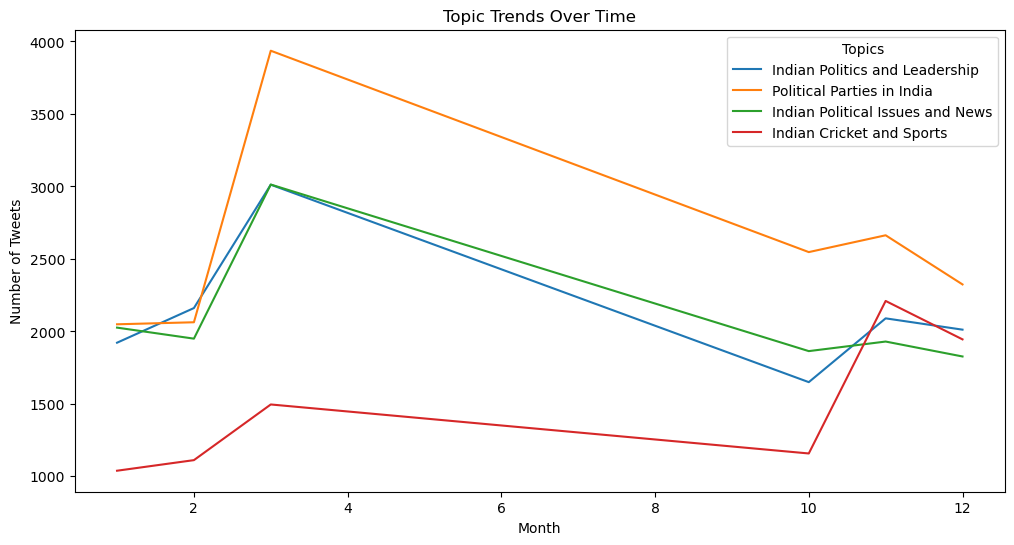

In [180]:
# Group data by month and topic
monthly_topic_counts = data.groupby(['Prcsd_Year', 'Prcsd_Month', 'Topic'])['Tweet'].count().reset_index()

# Pivot the data for plotting
monthly_topic_pivot = monthly_topic_counts.pivot_table(index=['Prcsd_Year', 'Prcsd_Month'], columns='Topic', values='Tweet', fill_value=0)

# Reset the index
monthly_topic_pivot.reset_index(inplace=True)

# Create a line plot to visualize topic trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_topic_pivot, x='Prcsd_Month', y='Indian Politics and Leadership', label='Indian Politics and Leadership')
sns.lineplot(data=monthly_topic_pivot, x='Prcsd_Month', y='Political Parties in India', label='Political Parties in India')
sns.lineplot(data=monthly_topic_pivot, x='Prcsd_Month', y='Indian Political Issues and News', label='Indian Political Issues and News')
sns.lineplot(data=monthly_topic_pivot, x='Prcsd_Month', y='Indian Cricket and Sports', label='Indian Cricket and Sports')

plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.title('Topic Trends Over Time')
plt.legend(title='Topics')
plt.show()